In [45]:
import os, sys, librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import IPython.display as ipd

from utils.plot_tools import plot_segments

- 주어진 음악 녹음에서 구조적인 정보를 추출하는 다양한 절차를 설명한 바 있다. 그러나 주어진 절차가 당면한 작업을 **얼마나 잘** 수행하는지 측정하는 문제에 대해서는 아직 논의한 바가 없다.
- 음악 처리 알고리즘을 (자동으로) 평가하는 문제는 구조 분석을 넘어서 그 자체로도 중요한 작업이다.
- 일반적인 평가 방식은 자동화된 절차로 얻은 **추정 결과(estimated result)** 를 일부 **참조 결과(reference result)** 와 비교하는 것이다.
- 이러한 일반적인 접근 방식을 구현하려면 다음 질문에 대한 답을 찾아야 한다.
     * 주어진 분석 결과는 실제로 어떻게 모델링되는가?
     * 추정 결과를 참조 결과와 어떻게 비교해야 하는가?
     * 참조 결과는 어떻게 구했으며 신뢰할 수 있는가?

- 특히 마지막 질문은 음악적 서술의 본질과 의미에 대한 철학적 고찰로 쉽게 이어진다.
- 예를 들어, 음악 구조 분석은 실제 음악 녹음에서 발생하는 음악적 및 음향적 변화 뿐만 아니라 다양한 요인에 의존하는 ill-posed 문제이다.
- 분석 결과는 음악적 맥락과 고려되는 시간적 수준에 크게 좌우되기 때문에 두 명의 전문가가 있다고 하더라도 주어진 음악에 대한 분석에 서로 동의하지 않을 수 있다.
- 브람스 예의 경우, 한 전문가는 음악적 구조 $A_1A_2B_1B_2CA_3B_3B_4D$가 되는 더 큰 규모의 구조에 주석을 달고, 다른 전문가는 부분이 더 세분화된 더 작은 규모를 고려할 수 있다.

- 다음 코드 셀에서는 세 가지 다른 축척에 대한 주석(annotation)의 예를 제공한다.

<!--<img src="../data/C4/FMP_C4_F28.png" width="300px" align="middle" alt="FMP_C4_F28">-->

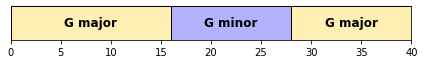

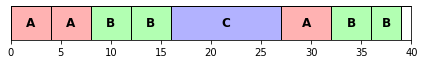

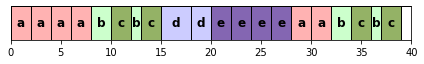

In [46]:
ann_Brahms = {}
ann_Brahms[0] = [[0, 16, 'G major'], [16, 28, 'G minor'], [28, 40, 'G major']]

ann_Brahms[1] = [[0, 4, 'A'], [4, 8, 'A'],  [8, 12, 'B'], [12, 16, 'B'],
                [16, 27, 'C'], [27, 32, 'A'], [32, 36, 'B'], [36, 39, 'B'], [39, 40, '']]

ann_Brahms[2] = [[0, 2, 'a'], [2, 4, 'a'], [4, 6, 'a'], [6, 8, 'a'],
                [8, 10, 'b'], [10, 12, 'c'], [12, 13, 'b'], [13, 15, 'c'],
                [15, 18, 'd'], [18, 20, 'd'], 
                [20, 22, 'e'], [22, 24, 'e'], [24, 26, 'e'], [26, 28, 'e'],
                [28, 30, 'a'], [30, 32, 'a'], 
                [32,34, 'b'], [34, 36, 'c'], [36, 37, 'b'], [37, 39, 'c'], [39, 40, '']]

color_ann_Brahms = {'G major': [1, 0.8, 0, 0.3], 'G minor': [0, 0, 1, 0.3],
    'A': [1, 0, 0, 0.3], 'B': [0, 1, 0, 0.3], 'C': [0, 0, 1, 0.3], '': [1, 1, 1, 0.3],
    'a': [1, 0, 0, 0.3], 'b': [0, 1, 0, 0.2], 'c': [0.3, 0.5, 0, 0.6], 
    'd': [0, 0, 1, 0.2], 'e': [0.2, 0, 0.5, 0.6],  '': [1, 1, 1, 1]}                    

figsize = (6,1)
for k in range(3):
    plot_segments(ann_Brahms[k], figsize = figsize, colors=color_ann_Brahms); 

- 실제로 단순하고 때로는 문제가 있는 가정이지만, 일반적으로 전문가에 의해 유효한 참조의 구조 주석(annotation) 하나가 주어졌다고 가정한다.
- 이러한 주석은 종종 **ground truth**라고도 한다.
- 자동화 절차의 목적은 가능한 이러한 참조에 가까운 주석을 추정하는 것이다.

# Precision, Recall, F-Measure

- 많은 평가 지표들이 precision(정밀도), recall(재현율), 그리고 F-measure에 기반한다.

 - 우선 $\mathcal{I}$를 아이템(items)이라고 하는 유한 집합이라고 하자. 
    - 각 아이템 $i\in \mathcal{I}$은 라벨 '$+$' (**positive** or **relevant**) 혹은 라벨 '$-$' (**negative** or **not relevant**)로 지정된다. 
    
    
- $\mathcal{I}^\mathrm{Ref}_+$를 양의 아이템, $\mathcal{I}^\mathrm{Ref}_-$를 음의 아이템의 집합이라고 하자.
- $\mathcal{I}^\mathrm{Est}_+$를 양으로 추정된 아이템, $\mathcal{I}^\mathrm{Est}_-$를 음으로 추정된 아이템의 집합이라고 하자.


- $i\in\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+$ 이면 **true positive** (TP)
- $i\in\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_-$ 이면 **false positive** (FP)
- $i\in\mathcal{I}^\mathrm{Est}_-\cap\mathcal{I}^\mathrm{Ref}_+$ 이면 **false negative** (FN)
- $i\in\mathcal{I}^\mathrm{Est}_-\cap\mathcal{I}^\mathrm{Ref}_-$ 이면 **true negative** (TN)


- **precision** $\mathrm{P}$은 true positives의 수를 positive로 추정한 모든 아이템으로 나눈 것이다:

\begin{equation}
   \mathrm{P} = \frac{|\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+|}{|\mathcal{I}^\mathrm{Est}_+|} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FP}}.  
\end{equation}

- **recall** $\mathrm{R}$은 true positives의 수를 전체 positive 아이템으로 나눈 것이다:

\begin{equation}
   \mathrm{R} = \frac{|\mathcal{I}^\mathrm{Est}_+\cap\mathcal{I}^\mathrm{Ref}_+|}{|\mathcal{I}^\mathrm{Ref}_+|} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FN}}.  
\end{equation}

- precision과 recall 모두 $[0,1]$에 있다. 
- $\mathrm{P}=1$는 양으로 추정한 모든 아이템이 실제로 양인 경우이며, 이 경우 false positive가 없으나 false negative는 있을 수 있다.
- $\mathrm{R}=1$는 모든 양의 아이템이 양으로 추정되었음을 의미하며, 이 경우 false negative가 없으나 false positive는 있을 수 있다.
- $\mathrm{P}=1$이면서 $\mathrm{R}=1$일 때만 추정 annotation과 참조 annotation이 일치하는 경우이다.


- Precision과 recall은 종종 **F-measure**라고 하는 단일 측정값을 형성하기 위해 **조화 평균**을 사용하여 결합된다.

\begin{equation}
   \mathrm{F} = \frac{2\cdot \mathrm{P}\cdot \mathrm{R}}{\mathrm{P} + \mathrm{R}}
\end{equation}

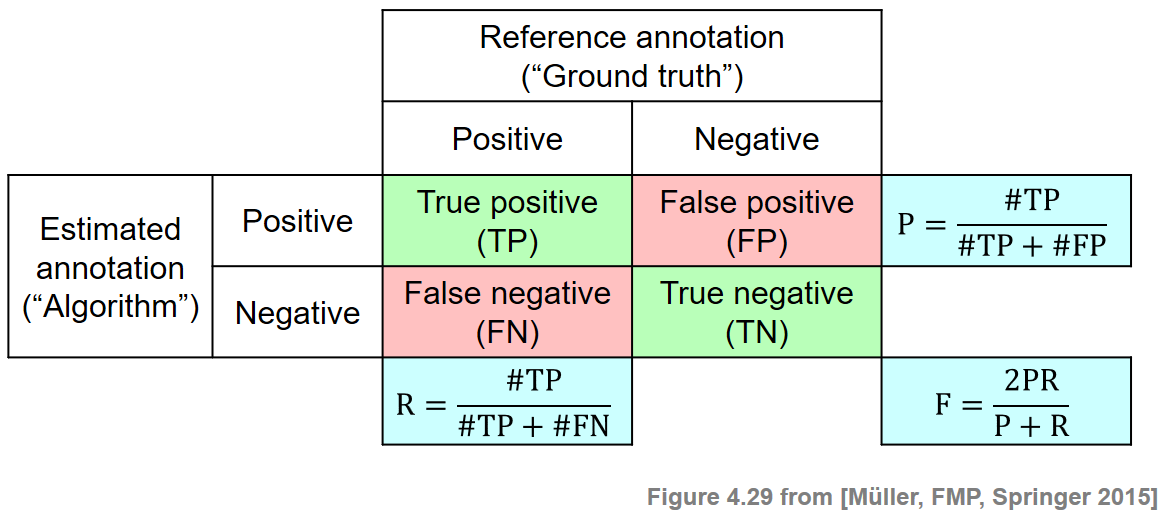

In [47]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F29.png",width=500)

In [48]:
def measure_prf(num_TP, num_FN, num_FP):
    """Compute P, R, and F from size of TP, FN, and FP [FMP, Section 4.5.1]

    Args:
        num_TP (int): True positives
        num_FN (int): False negative
        num_FP (int): False positives

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
    """
    P = num_TP / (num_TP + num_FP)
    R = num_TP / (num_TP + num_FN)
    if (P + R) > 0:
        F = 2 * P * R / (P + R)
    else:
        F = 0
    return P, R, F
    

def measure_prf_sets(I, I_ref_pos, I_est_pos, details=False):
    """Compute P, R, and F from sets I, I_ref_pos, I_est_pos [FMP, Section 4.5.1]

    Args:
        I: Set of items
        I_ref_pos: Reference set of positive items
        I_est_pos: Set of items being estimated as positive
        details: Print details (Default value = False)

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
    """
    I_ref_neg = I.difference(I_ref_pos)
    I_est_neg = I.difference(I_est_pos)
    TP = I_est_pos.intersection(I_ref_pos)
    FN = I_est_neg.intersection(I_ref_pos)
    FP = I_est_pos.intersection(I_ref_neg)
    P, R, F = measure_prf(len(TP), len(FN), len(FP))
    if details:
        print('TP = ', TP, ';  FN = ', FN, ';  FP = ', FP)
        print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))
    return P, R, F

# 라벨링 평가 (Labeling Evaluation)

- 프레임 수준의 음악 분석 작업을 고려해보자.
- $\varphi:[1:N]$를 프레임으로 주어진 시간 축으로 하고 $\Lambda$를 가능한 레이블 집합이라고 하자.
- **레이블 함수(label function)** 는 각 프레임 인덱스 $n\in[1:N]$에 레이블 $\varphi(n)\in\Lambda$를 할당하는 함수 $\varphi:[1:N] \to \Lambda$로 정의한다.

- 이제 **pair-wise precision**, **pair-wise recall** 및 **pair-wise F-measure**라고 하는 몇 가지 프레임 기반 평가 측정값을 소개한다.
- $\varphi^\mathrm{Ref}$ 및 $\varphi^\mathrm{Est}$를 각각 참조 및 추정 구조 주석에 대한 레이블 함수로 둔다.
- 실제 레이블 네이밍에서 독립적이기 위해서는, 레이블을 직접 보지 않고 레이블 동시 발생을 찾는 것이 주요 아이디어다.
- 이를 위해 동일한 레이블에 할당된 프레임 쌍(pair)을 고려한다.

\begin{equation}
   \mathcal{I}=\{(n,m)\in[1:N]\times[1:N]\mid m<n\},
\end{equation}

- 참조 및 추정 주석에 대해 양의 아이템을 다음과 같이 정의한다. 
\begin{eqnarray}
   \mathcal{I}^\mathrm{Ref}_+&=&\{(n,m)\in\mathcal{I}\mid \varphi^\mathrm{Ref}(n)=\varphi^\mathrm{Ref}(m)\},\\
   \mathcal{I}^\mathrm{Est}_+&=&\{(n,m)\in\mathcal{I}\mid \varphi^\mathrm{Est}(n)=\varphi^\mathrm{Est}(m)\},
\end{eqnarray}

    - whereas $\mathcal{I}^\mathrm{Ref}_-=\mathcal{I}\setminus\mathcal{I}^\mathrm{Ref}_+$ and $\mathcal{I}^\mathrm{Est}_-=\mathcal{I}\setminus\mathcal{I}^\mathrm{Est}_+$. 

- 즉, $(n,m)$ 항목은 프레임 $n$과 $m$이 동일한 레이블을 갖는 경우 주석에 대해 **양(positive)** 으로 간주된다.
- 이제 **pairwise precision**는 이 이진 분류 체계의 precision으로 정의된다.
- 유사하게 **pairwise recall**와 **pairwise F-measure**은 위의 체계의 recall 및 F-measure이다.

- 다음 두 예에서 샘플링된 시간 간격은 $N=10$ 샘플로 구성된다.

In [49]:
def convert_ann_to_seq_label(ann):
    """Convert structure annotation with integer time positions (given in indices)
    into label sequence

    Args:
        ann (list): Annotation (list ``[[s, t, 'label'], ...]``, with ``s``, ``t`` being integers)

    Returns:
        X (list): Sequencs of labels
    """
    X = []
    for seg in ann:
        K = seg[1] - seg[0]
        for k in range(K):
            X.append(seg[2])
    return X

    
def plot_seq_label(ax, X, Fs=1, color_label=[], direction='horizontal',
                   fontsize=10, time_axis=False, print_labels=True):
    """Plot label sequence in the style of annotations

    Args:
        ax: Axis used for plotting
        X: Label sequence
        Fs: Sampling rate (Default value = 1)
        color_label: List of colors for labels (Default value = [])
        direction: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = 'horizontal')
        fontsize: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = 10)
        time_axis: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = False)
        print_labels: Parameter used for :func:`libfmp.b.b_plot.plot_segments` (Default value = True)

    Returns:
         ann_X: Structure annotation for label sequence
    """
    ann_X = []
    for m, cur_x in enumerate(X):
        ann_X.append([(m-0.5)/Fs, (m+0.5)/Fs, cur_x])
    plot_segments(ann_X, ax=ax, time_axis=time_axis, fontsize=fontsize,
                           direction=direction, colors=color_label, print_labels=print_labels)
    return ann_X

Segment-based structure annotation:


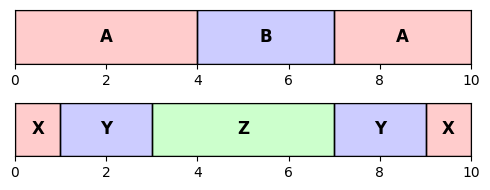

Frame-based label sequence:


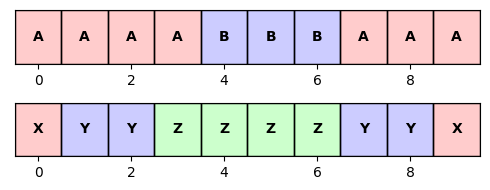

In [50]:
color_label = {'A': [1, 0, 0, 0.2], 'B': [0, 0, 1, 0.2], 'C': [0, 1, 0, 0.2],
             'X': [1, 0, 0, 0.2], 'Y': [0, 0, 1, 0.2], 'Z': [0, 1, 0, 0.2]}

ann_ref = [[0, 4, 'A'], [4, 7, 'B'], [7, 10, 'A']]
ann_est = [[0, 1, 'X'], [1, 3, 'Y'], [3, 7, 'Z'], [7, 9, 'Y'], [9, 10, 'X']]

X_ref = convert_ann_to_seq_label(ann_ref)
X_est = convert_ann_to_seq_label(ann_est)

print('Segment-based structure annotation:')
plt.figure(figsize=(5,2))
ax = plt.subplot(211)
plot_segments(ann_ref, ax=ax, colors=color_label); 
#ax.set_xticks([])
ax = plt.subplot(212)
plot_segments(ann_est, ax=ax, colors=color_label); 
#ax.set_xticks([])
plt.tight_layout()
plt.show()

print('Frame-based label sequence:')
plt.figure(figsize=(5,2))
ax = plt.subplot(211)
plot_seq_label(ax, X_ref, color_label=color_label, time_axis=True);
ax = plt.subplot(212)
plot_seq_label(ax, X_est, color_label=color_label, time_axis=True);
plt.tight_layout()

- 첫 번째 시퀀스를 참조 $\varphi^\mathrm{Est}$로 사용하고, 두 번째 시퀀스를 추정 $\varphi^\mathrm{Est}$로 사용하여 이제 pairwise precision, recall, F-measure를 설명한다 
- 특히 참조 및 추정 주석의 양의 항목(회색 항목으로 표시)을 표시한다.
- 또한 true positive (TP), false negative (FN), false positive (FP) 항목을 시각화한다.

In [51]:
def compare_pairwise(X):
    """Compute set of positive items from label sequence [FMP, Section 4.5.3]

    Args:
        X (list or np.ndarray): Label sequence

    Returns:
        I_pos (np.ndarray): Set of positive items
    """
    N = len(X)
    I_pos = np.zeros((N, N))
    for n in range(1, N):
        for m in range(n):
            if X[n] is X[m]:
                I_pos[n, m] = 1
    return I_pos


def evaluate_pairwise(I_ref_pos, I_est_pos):
    """Compute pairwise evaluation measures [FMP, Section 4.5.3]

    Args:
        I_ref_pos (np.ndarray): Referenence set of positive items
        I_est_pos (np.ndarray): Set of items being estimated as positive

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
        I_eval (np.ndarray): Data structure encoding TP, FN, FP
    """
    I_eval = np.zeros(I_ref_pos.shape)
    TP = (I_ref_pos + I_est_pos) > 1
    FN = (I_ref_pos - I_est_pos) > 0
    FP = (I_ref_pos - I_est_pos) < 0
    I_eval[TP] = 1
    I_eval[FN] = 2
    I_eval[FP] = 3
    num_TP = np.sum(TP)
    num_FN = np.sum(FN)
    num_FP = np.sum(FP)
    P, R, F = measure_prf(num_TP, num_FN, num_FP)
    return P, R, F, num_TP, num_FN, num_FP, I_eval


def plot_matrix_label(M, X, color_label=None, figsize=(3, 3), cmap='gray_r', fontsize=8, print_labels=True):
    """Plot matrix and label sequence

    Args:
        M: Matrix
        X: Label sequence
        color_label: List of colors for labels (Default value = None)
        figsize: Figure size (Default value = (3, 3))
        cmap: Colormap for imshow (Default value = 'gray_r')
        fontsize: Font size (Default value = 8)
        print_labels: Display labels inside Rectangles (Default value = True)

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    fig, ax = plt.subplots(2, 3, gridspec_kw={'width_ratios': [0.1, 1, 0.05],
                                              'wspace': 0.2, 'height_ratios': [1, 0.1]},
                           figsize=figsize)

    colorList = np.array([[1, 1, 1, 1],  [0, 0, 0, 0.7]])
    cmap = ListedColormap(colorList)
    im = ax[0, 1].imshow(M, aspect='auto', cmap=cmap,  origin='lower', interpolation='nearest')
    im.set_clim(vmin=-0.5, vmax=1.5)
    ax_cb = plt.colorbar(im, cax=ax[0, 2])
    ax_cb.set_ticks(np.arange(0, 2, 1))
    ax_cb.set_ticklabels(np.arange(0, 2, 1))
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    plot_seq_label(ax[1, 1], X, color_label=color_label, fontsize=fontsize, print_labels=print_labels)
    ax[1, 2].axis('off')
    ax[1, 0].axis('off')
    plot_seq_label(ax[0, 0], X, color_label=color_label, fontsize=fontsize, print_labels=print_labels,
                   direction='vertical')
    return fig, ax


def plot_matrix_pairwise(I_eval, figsize=(3, 2.5)):
    """Plot matrix I_eval encoding TP, FN, FP (see :func:`libfmp.c4.c4s5_evaluation.evaluate_pairwise`)

   Args:
        I_eval: Data structure encoding TP, FN, FP
        figsize: Figure size (Default value = (3, 2.5))

    Returns:
        fig: Handle for figure
        im: Handle for imshow
    """
    fig = plt.figure(figsize=figsize)
    colorList = np.array([[1, 1, 1, 1], [0, 0.7, 0, 1], [1, 0, 0, 1], [1, 0.5, 0.5, 1]])
    cmap = ListedColormap(colorList)
    im = plt.imshow(I_eval, aspect='auto', cmap=cmap,  origin='lower', interpolation='nearest')
    im.set_clim(vmin=-0.5, vmax=3.5)
    plt.xticks([])
    plt.yticks([])
    ax_cb = plt.colorbar(im)
    ax_cb.set_ticks(np.arange(0, 4, 1))
    ax_cb.set_ticklabels(['', 'TP', 'FN', 'FP'])
    return fig, im

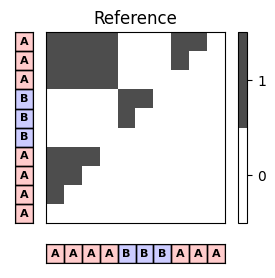

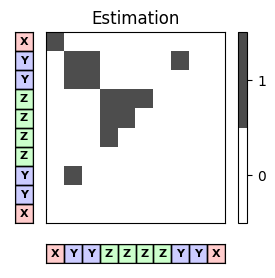

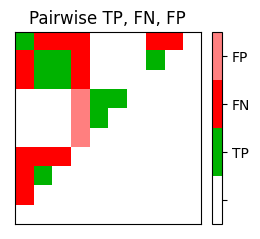

#TP =  10 
#FN =  14 
#FP =  3
precision = 0.7692
recall = 0.4167
F-measure = 0.5405


In [52]:
I_ref_pos = compare_pairwise(X_ref)
fig, ax = plot_matrix_label(I_ref_pos, X_ref, color_label=color_label)
ax[0,1].set_title('Reference')

I_est_pos = compare_pairwise(X_est)
fig, ax = plot_matrix_label(I_est_pos, X_est, color_label=color_label)
ax[0,1].set_title('Estimation')

P, R, F, num_TP, num_FN, num_FP, I_eval =  evaluate_pairwise(I_ref_pos, I_est_pos)
fig, im = plot_matrix_pairwise(I_eval)
plt.title('Pairwise TP, FN, FP')

plt.show()

print('#TP = ', num_TP, '\n#FN = ', num_FN, '\n#FP = ', num_FP)
print('precision = %0.4f\nrecall = %0.4f\nF-measure = %0.4f' % (P, R, F))

- 첫 번째 그림에 참조 주석이 표시된다. $45$ 아이템 중 $24$는 이 주석과 관련하여 positive(회색 상자로 표시됨)이다.
- 추정된 주석을 나타내는 두 번째 그림에는 $13$의 positive 항목이 있다(회색 상자로 표시됨).
- 세 번째 그림에서 true positive($\#\mathrm{TP}=10$), false positive ($\#\mathrm{FP}=3$) 및 false negative($\#\mathrm{FN) }=14$)가 표시된다.


- 이로부터 다음을 얻을 수 있다.
\begin{eqnarray}
\mathrm{P} &=& \#\mathrm{TP}/(\#\mathrm{TP}+\#\mathrm{FP})=10/13\approx 0.769,\\
\mathrm{R} &=& \#\mathrm{TP}/(\#\mathrm{TP}+\#\mathrm{FN})=10/24\approx 0.417,\\
\mathrm{F} &=& 2\mathrm{P}\mathrm{R}/(\mathrm{P} + \mathrm{R})\approx 0.541. 
\end{eqnarray}

- 이 예에서 거의 $77\%$의 precision은 상대적으로 높은 반면 $42\%$의 recall은 상대적으로 낮다.
- F-measure은 이 두 값 사이이며 더 작은 쪽으로 편향된다.

- 추가 예시로 브람스 주석을 보자.

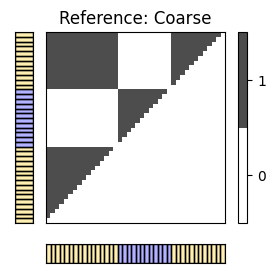

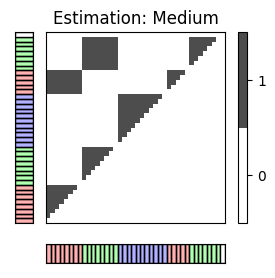

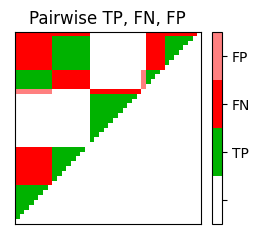

#TP =  226 ;  #FN =  218 ;  #FP =  12
P = 0.950;  R = 0.509;  F = 0.663



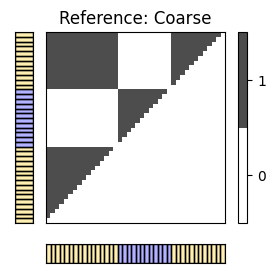

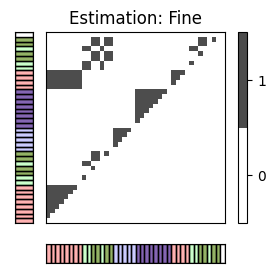

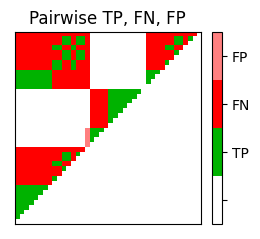

#TP =  143 ;  #FN =  301 ;  #FP =  4
P = 0.973;  R = 0.322;  F = 0.484



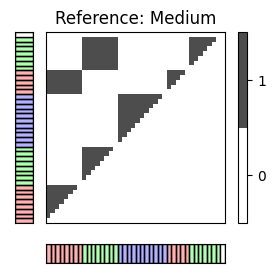

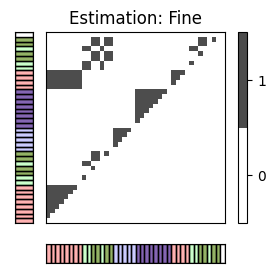

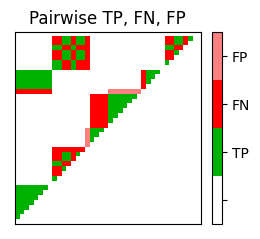

#TP =  136 ;  #FN =  102 ;  #FP =  11
P = 0.925;  R = 0.571;  F = 0.706



In [53]:
X_0 = convert_ann_to_seq_label(ann_Brahms[0])
X_1 = convert_ann_to_seq_label(ann_Brahms[1])
X_2 = convert_ann_to_seq_label(ann_Brahms[2])

X_set = [X_0, X_1, X_2]
combinations = [(0,1), (0,2), (1,2)]
case_label = ['Coarse', 'Medium', 'Fine']

for c in combinations:
    X_ref = X_set[c[0]]
    X_est = X_set[c[1]]
    
    I_ref_pos = compare_pairwise(X_ref)
    fig, ax = plot_matrix_label(I_ref_pos, X_ref, color_label=color_ann_Brahms, print_labels=False)
    ax[0,1].set_title('Reference: '+case_label[c[0]])
    
    I_est_pos = compare_pairwise(X_est)
    fig, ax = plot_matrix_label(I_est_pos, X_est, color_label=color_ann_Brahms, print_labels=False)
    ax[0,1].set_title('Estimation: '+case_label[c[1]])

    P, R, F, num_TP, num_FN, num_FP, I_eval =  evaluate_pairwise(I_ref_pos, I_est_pos)
    fig, im = plot_matrix_pairwise(I_eval)
    plt.title('Pairwise TP, FN, FP')
    
    plt.show()
    
    print('#TP = ', num_TP, ';  #FN = ', num_FN, ';  #FP = ', num_FP)
    print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))
    print()

# 경계 평가 (Boundary Evaluation)

- pairwise precision, recall, F-measure은 전적으로 레이블 정보를 기반으로 하는 반면, 세그먼트 경계는 레이블 변경의 존재에 의해 암시적으로 처리된다.
- 참신성(novelty) 기반 분할과 같은 다른 구조 분석 작업의 경우 경계의 정확한 감지가 중요하다.
- 이러한 절차를 평가하기 위해 참조 주석의 경계에서 추정된 세그먼트 경계의 편차를 측정한다.
- 이를 수학적으로 모델링하기 위해 시퀀스로 제공되는 **경계 주석(boundary annotation)** 개념을 도입한다.
    - $B=(b_1,b_2,\ldots,b_K)$
    - $b_k\in[1:N]$, $k\in[1:K]$는 증가하는 인덱스

- 예를 들어, 이러한 경계 주석은 주석이 달린 세그먼트의 시작 및 가능한 끝 인덱스를 취함으로써 구조 주석에서 유도될 수 있다.

- $B^\mathrm{Ref}$를 참조 경계 주석, $B^\mathrm{Est}$를 추정 경계 주석이라고 하자.
- $B^\mathrm{Est}$와 $B^\mathrm{Ref}$를 비교하는 방법에는 여러 가지가 있다.
- 예를 들어 $\mathcal{I}=[1:N]$ 집합을 사용하면 $\mathcal{I}^\mathrm{Ref}_+:=B^\mathrm{Ref}$ 및 $\mathcal{I}^\mathrm{Est}_+:=B^\mathrm{Est}$를 정의할 수 있다. .
- 이로부터 Precision, Recall, F-Measure를 일반적인 방법으로 계산할 수 있다.
- 이 경우 추정된 경계는 참조 경계와 일치하는 경우에만 올바른 것으로 간주된다.

- 특정 응용의 경우 경계 위치의 작은 편차가 허용된다. 따라서 최대 허용 편차에 대한 tolerance 매개변수 $\tau\geq 0$를 도입하여 이전 측정을 일반화한다.
- 추정된 경계 $b^\mathrm{Est}\in B^\mathrm{Est}$는 참조 경계 $b^\mathrm{Ref}\in B^\mathrm{Ref}$의 $\tau$-neighborhood 내에 있는 경우 **올바른** 것으로 간주된다.:
\begin{equation}
   |b^\mathrm{Est}-b^\mathrm{Ref}|\leq \tau.
\end{equation}

- 이 경우 $\mathcal{I}^\mathrm{Ref}_+$ 및 $\mathcal{I}^\mathrm{Est}_+$ 집합은 더 이상 정밀도 및 재현율을 정의하는 데 사용할 수 없다.
- 대신, 우리는 true positives, false positives, 및 false negatives의 개념을 일반화한다.
- **true positive**(TP)은 올바른 항목 $b^\mathrm{Est}\in B^\mathrm{Est}$로 정의되고 **false positive**(FP)은 올바르지 않은 $b^\mathrm{Est}\in B^\mathrm{Est}$ 항목이다. 또한, **false negative**(FN)은 $\tau$-neighborhood에 추정 항목이 없는 $b^\mathrm{Ref}\in B^\mathrm{Ref}$ 항목으로 정의된다.
- 이러한 정의에 따라 이전과 같이 $\#\mathrm{TP}$, $\#\mathrm{FP}$ 및 $\#\mathrm{FN}$에서 정밀도, 재현율 및 F-measure을 계산할 수 있다.

- 그러나 이러한 일반화는 주의해야 할 점이 있다. tolerance 매개변수 $\tau$로 인해 여러 추정 경계가 단일 참조 경계의 $\tau$-이웃에 포함될 수 있다. 반대로, 여러 참조 경계의 $\tau$-neighborhood에 단일 추정 경계가 포함될 수도 있다.

- 결과적으로 $B^\mathrm{Est}$와 $B^\mathrm{Ref}$가 서로 다른 수의 경계를 포함하는 경우에도 완벽한 F-measure을 얻을 수 있다. 이것은 의미가 없다.

- 이러한 변칙을 피하기 위해 다음을 요구하는 경계 주석의 정의의 가정을 추가할 수 있다.
    - $|b_{k+1}-b_k| > 2\tau$
    - for $k\in[1:N-1]$
- 이것은 또한 음악적 관점에서 의미 있는 요구 사항입니다. 음악 섹션(두 개의 후속 경계로 결정됨)은 허용 오차 매개변수의 크기보다 훨씬 길어야 한다. 

- 다음 그림은 간단한 예를 통해 경계 평가 측정을 보여준다.

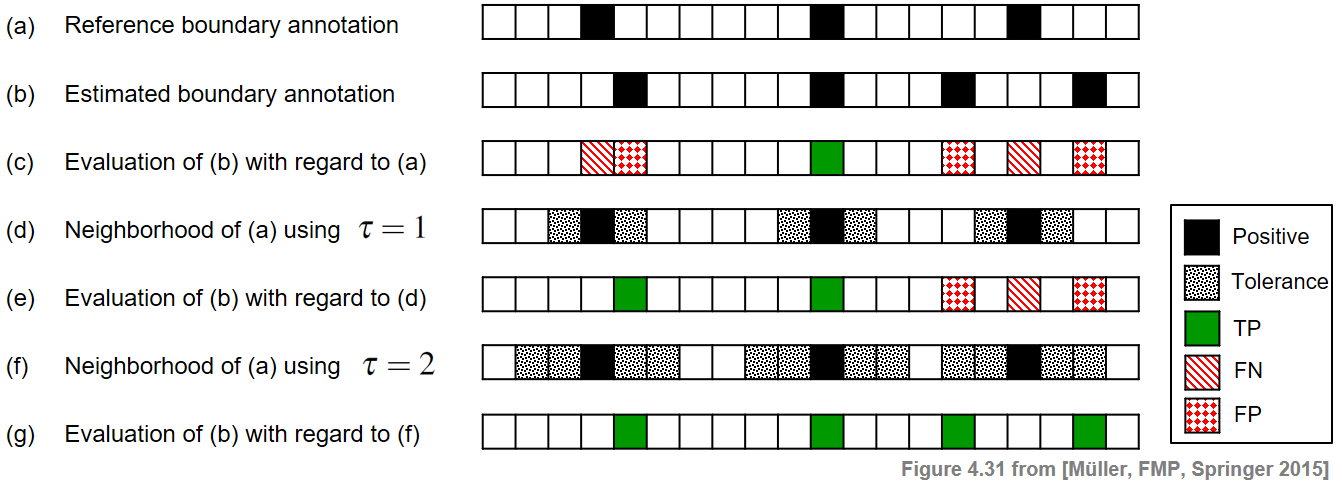

In [61]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F31_text.png", width=800)

* 공차(tolerance) 매개변수 $\tau=0$((c) 참조)를 사용하여 $\#\mathrm{TP}=1$, $\#\mathrm{FP}=3$ 및 $\#\mathrm{FN}=2$을 얻는다. $\mathrm{P}=1/4$, $\mathrm{R}=1/3$ 및 $\mathrm{F}=2/7$ 이다.

* $\tau=1$의 경우((e) 참조) $\#\mathrm{TP}=2$, $\#\mathrm{FP}=2$, $\#\mathrm{FN}=1$, 결과는 $\mathrm{P}=1/2$, $\mathrm{R}=2/3$ 및 $\mathrm{F}=4/7$이다.

* 마지막으로 $\tau=2$((g) 참조)를 사용하면 완벽한 F-measure을 얻을 수 있다. 그러나 이 경우 최소 거리 조건을 위반하고 평가 척도의 의미가 없다.

In [58]:
def evaluate_boundary(B_ref, B_est, tau):
    """Compute boundary evaluation measures [FMP, Section 4.5.4]

    Args:
        B_ref (np.ndarray): Reference boundary annotations
        B_est (np.ndarray): Estimated boundary annotations
        tau (int): Tolerance parameter.
            Note: Condition ``|b_{k+1}-b_k|>2tau`` should be fulfilled [FMP, Eq. 4.58]

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
        B_tol (np.ndarray): Data structure encoding B_ref with tolerance
        I_eval (np.ndarray): Data structure encoding TP, FN, FP
    """
    N = len(B_ref)
    num_TP = 0
    num_FN = 0
    num_FP = 0
    B_tol = np.zeros((np.array([B_ref])).shape)
    B_eval = np.zeros((np.array([B_ref])).shape)
    for n in range(N):
        min_idx = max(0, n - tau)
        max_idx = min(N - 1, n + tau)
        if B_ref[n] == 1:
            B_tol[:, min_idx:max_idx+1] = 2
            B_tol[:, n] = 1
            temp = sum(B_est[min_idx:max_idx+1])
            if temp > 0:
                num_TP += temp
            else:
                num_FN += 1
                B_eval[:, n] = 2
        if B_est[n] == 1:
            if sum(B_ref[min_idx:max_idx+1]) == 0:
                num_FP += 1
                B_eval[:, n] = 3
            else:
                B_eval[:, n] = 1
    P, R, F = measure_prf(num_TP, num_FN, num_FP)
    return P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval


def plot_boundary_measures(B_ref, B_est, tau, figsize=(8, 2.5)):
    """Plot B_ref and B_est (see :func:`libfmp.c4.c4s5_evaluation.evaluate_boundary`)

    Args:
        B_ref: Reference boundary annotations
        B_est: Estimated boundary annotations
        tau: Tolerance parameter
        figsize: Figure size (Default value = (8, 2.5))

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval = evaluate_boundary(B_ref, B_est, tau)

    colorList = np.array([[1., 1., 1., 1.], [0., 0., 0., 1.], [0.7, 0.7, 0.7, 1.]])
    cmap_tol = ListedColormap(colorList)
    colorList = np.array([[1, 1, 1, 1], [0, 0.7, 0, 1], [1, 0, 0, 1], [1, 0.5, 0.5, 1]])
    cmap_measures = ListedColormap(colorList)

    fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.02],
                                              'wspace': 0.2, 'height_ratios': [1, 1, 1]},
                           figsize=figsize)

    im = ax[0, 0].imshow(B_tol, cmap=cmap_tol, interpolation='nearest')
    ax[0, 0].set_title('Reference boundaries (with tolerance)')
    im.set_clim(vmin=-0.5, vmax=2.5)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[0, 1])
    ax_cb.set_ticks(np.arange(0, 3, 1))
    ax_cb.set_ticklabels(['', 'Positive', 'Tolerance'])

    im = ax[1, 0].imshow(np.array([B_est]), cmap=cmap_tol, interpolation='nearest')
    ax[1, 0].set_title('Estimated boundaries')
    im.set_clim(vmin=-0.5, vmax=2.5)
    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[1, 1])
    ax_cb.set_ticks(np.arange(0, 3, 1))
    ax_cb.set_ticklabels(['', 'Positive', 'Tolerance'])

    im = ax[2, 0].imshow(B_eval, cmap=cmap_measures, interpolation='nearest')
    ax[2, 0].set_title('Evaluation')
    im.set_clim(vmin=-0.5, vmax=3.5)
    ax[2, 0].set_xticks([])
    ax[2, 0].set_yticks([])
    ax_cb = plt.colorbar(im, cax=ax[2, 1])
    ax_cb.set_ticks(np.arange(0, 4, 1))
    ax_cb.set_ticklabels(['', 'TP', 'FN', 'FP'])
    plt.show()
    return fig, ax

====== Evaluation using tau = 0 ======
#TP =  1 ;  #FN =  2 ;  #FP =  3
P = 0.250;  R = 0.333;  F = 0.286


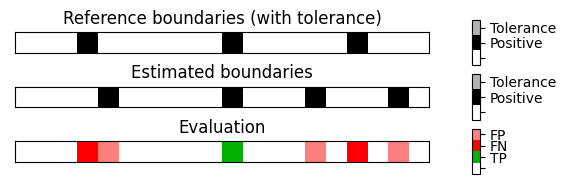

====== Evaluation using tau = 1 ======
#TP =  2 ;  #FN =  1 ;  #FP =  2
P = 0.500;  R = 0.667;  F = 0.571


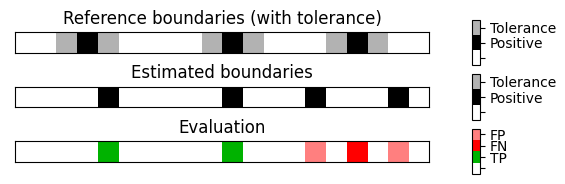

====== Evaluation using tau = 2 ======
#TP =  4 ;  #FN =  0 ;  #FP =  0
P = 1.000;  R = 1.000;  F = 1.000


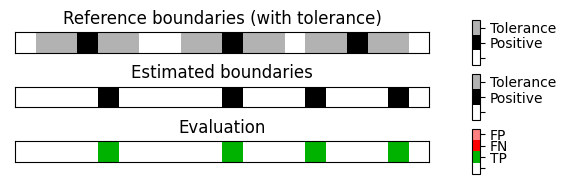

In [62]:
B_ref = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
B_est = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
tau_list = [0,1,2]

for tau in tau_list:
    print('====== Evaluation using tau = %d ======'%tau)
    P, R, F, num_TP, num_FN, num_FP, B_tol, B_eval = evaluate_boundary(B_ref, B_est, tau)    
    print('#TP = ', num_TP, ';  #FN = ', num_FN, ';  #FP = ', num_FP)
    print('P = %0.3f;  R = %0.3f;  F = %0.3f' % (P, R, F))
    fig, ax = plot_boundary_measures(B_ref, B_est, tau=tau, figsize=(6,2))

# 파이썬 라이브러리 `mir_eval`

- https://craffel.github.io/mir_eval/#module-mir_eval.segment

In [64]:
import mir_eval

In [71]:
# (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals('ref.lab')
# (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals('est.lab')

In [72]:
# Trim or pad the estimate to match reference timing
(ref_intervals,
 ref_labels) = mir_eval.util.adjust_intervals(ref_intervals,
                                              ref_labels,
                                              t_min=0)
(est_intervals,
 est_labels) = mir_eval.util.adjust_intervals(
    est_intervals, est_labels, t_min=0, t_max=ref_intervals.max())

precision, recall, f = mir_eval.structure.pairwise(ref_intervals,
                                                   ref_labels,
                                                   est_intervals,
                                                   est_labels)

NameError: name 'ref_intervals' is not defined